In [1]:
%matplotlib inline

# Assignment 3

**DUE: Sunday November 6, 2022 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [2]:
NAME = "Marian Zlateva"
STUDENT_ID = "1797310"

## Question 1 - Logistic Regression
---
In this question, you will build a system for predicting patient deaths in the Intensive Care Unit (ICU) using the large [PhysioNet Computing in Cardiology Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/). For each patient in the dataset, demographic variables and time series of physiological variables were collected during their stay in the ICU. 

The risk prediction system you will build could in principle be used to flag patients as being at risk of death so that physicians could intervene and improve their outcome. To be confident about the impact of such a system, you would need to run an experiment. In this question, you will use a model in order to estimate the potential impact of the system.

The data you will be working with is all available from [PhysioNet](https://physionet.org/challenge/2012/). You will be looking at only the data in "Training set A". The patient data files are [https://archive.physionet.org/challenge/2012/set-a.zip](here), and the outcomes file is [https://archive.physionet.org/challenge/2012/Outcomes-a.txt](here).





#### Downloading and Reading in the Data

First, we download the physiological data and read in patient outcomes file (links above).

We want this data to be read from text files and assembled into a dataframe. To do so, please run the following code which will first define a function that reads a text file, and then runs that function on all the files and assembles the outputs into a single dataframe.

#### Downloading the data

In [3]:
!wget https://archive.physionet.org/challenge/2012/set-a.zip -O ./set-a.zip
import zipfile
with zipfile.ZipFile('./set-a.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

--2022-11-07 03:41:35--  https://archive.physionet.org/challenge/2012/set-a.zip
Resolving archive.physionet.org (archive.physionet.org)... 128.30.30.88
Connecting to archive.physionet.org (archive.physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7938449 (7.6M) [application/zip]
Saving to: ‘./set-a.zip’

./set-a.zip         100%[===================>]   7.57M  11.6MB/s    in 0.7s    

2022-11-07 03:41:36 (11.6 MB/s) - ‘./set-a.zip’ saved [7938449/7938449]



#### Reading in data

In [4]:
import pandas as pd
import numpy as np
import glob

def comp_patient(patdat, attrs):
    patdat[patdat == -1.0] = float('NaN')
    patdat_dict = {}
    for attr in attrs:
        patdat_dict[attr] = [patdat["Value"][patdat["Parameter"]==attr].mean(axis = 0)]
    return patdat_dict


attrs = ["Age", "Gender", "Height", "Weight", "Urine", 
         "HR", "Temp", "NIDiasABP", "SysABP", "DiasABP", "pH",
         "PaCO2", "PaO2", "Platelets", "MAP", "K", "Na", "FiO2", "GCS", "RecordID"]


full_dat  = pd.DataFrame(columns = attrs)

# Now let's take the list "all_pat_dat" and assemble it into a dataframe.
filenames = sorted(glob.glob("/content/set-a/*.txt"))
for filename in filenames:
    data = open(filename)
    patient_dat_full = pd.read_csv(data, delimiter=',')
    patient_dat = pd.DataFrame.from_dict(comp_patient(patient_dat_full, attrs))
    full_dat = full_dat.append(patient_dat)

outcome_dat = pd.read_csv("https://archive.physionet.org/challenge/2012/Outcomes-a.txt")
outcome_dat[outcome_dat == -1] = float('NaN') # set all -1 to NaNs
full_dat_out = full_dat.merge(outcome_dat, left_on='RecordID', right_on='RecordID')
full_dat_out.replace([np.inf, -np.inf], np.nan)

col_means = full_dat_out.mean()
# Set everything that's NaN to the mean of that column:

# Note: we do this for simplicity. Strictly speaking, you should
# only use the training set to compute the column means

for i in range(full_dat_out.shape[1]):
    mask = np.isnan(np.array(full_dat_out.iloc[:,i]))
    full_dat_out.iloc[mask, i] = col_means[i]



### a) Understanding the Data (2 points)
Looking at the files and the code provided above, explain:


*   What is the size of your input data? how many parameters exist in the data?
*   Exaplain what the code provided above is trying to achieve.



YOUR ANSWER HERE

### b) Run Logistic Regression (9 points)


Divide your data into training, validation, and test sets (60-20-20). 

Use the features `HR`, `Gender`, `age`, `temperature`, `weight`, `height`, `PaO2`, and  `PaCO2`, and fit a logistic regression model to predict in-hospital death. 

In [5]:
#Importing libraries
from sklearn.linear_model import LogisticRegression, LinearRegression
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math

In [6]:
full_dat_out.info()
full_dat_out.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                4000 non-null   float64
 1   Gender             4000 non-null   float64
 2   Height             4000 non-null   float64
 3   Weight             4000 non-null   float64
 4   Urine              4000 non-null   float64
 5   HR                 4000 non-null   float64
 6   Temp               4000 non-null   float64
 7   NIDiasABP          4000 non-null   float64
 8   SysABP             4000 non-null   float64
 9   DiasABP            4000 non-null   float64
 10  pH                 4000 non-null   float64
 11  PaCO2              4000 non-null   float64
 12  PaO2               4000 non-null   float64
 13  Platelets          4000 non-null   float64
 14  MAP                4000 non-null   float64
 15  K                  4000 non-null   float64
 16  Na                 4000 

,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,DiasABP,...,K,Na,FiO2,GCS,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,54.0,0.0,169.787227,83.043044,171.052632,70.810811,37.357143,50.147059,118.591225,59.543420,...,4.20,136.500000,0.549199,14.923077,132539.0,6.0,1.0,5.0,351.063772,0.0
1,76.0,1.0,175.300000,80.670588,151.560976,80.794118,36.939130,56.714286,113.411765,58.897059,...,3.90,137.000000,0.560000,13.333333,132540.0,16.0,8.0,8.0,351.063772,0.0
2,44.0,0.0,169.787227,56.700000,124.951220,83.759259,37.800000,79.000000,125.687500,67.125000,...,4.26,138.333333,0.500000,5.923077,132541.0,21.0,11.0,19.0,351.063772,0.0
3,68.0,1.0,180.300000,84.600000,545.833333,70.983333,36.223077,65.051724,118.591225,59.543420,...,4.00,139.333333,0.549199,14.944444,132543.0,7.0,1.0,9.0,575.000000,0.0
4,88.0,0.0,169.787227,83.043044,62.131579,74.958333,36.880000,45.720930,118.591225,59.543420,...,4.32,139.500000,0.549199,15.000000,132545.0,17.0,2.0,4.0,918.000000,0.0


In [7]:
#Cleaning and formatting the data

#no formatting needs to be done since all data is float64

def getOutliers(colName):
  full_dat_out_cleaned['calc'] = (full_dat_out_cleaned[colName] - full_dat_out_cleaned[colName].mean()) / full_dat_out_cleaned[colName].std()
  # print(full_dat_out_cleaned['calc'])

  outliers = full_dat_out_cleaned[ abs(full_dat_out_cleaned['calc']) > 4].index
  indexes = len(outliers)
  full_dat_out_cleaned.drop(outliers, inplace= True)

  print("REMOVED",colName, "outliers: ",indexes)

  full_dat_out_cleaned.drop(columns=['calc'],inplace=True)
  
  
full_dat_out_cleaned = full_dat_out.copy()
for col in full_dat_out.columns:
  getOutliers(col)

REMOVED Age outliers:  0
REMOVED Gender outliers:  0
REMOVED Height outliers:  16
REMOVED Weight outliers:  22
REMOVED Urine outliers:  20
REMOVED HR outliers:  0
REMOVED Temp outliers:  24
REMOVED NIDiasABP outliers:  4
REMOVED SysABP outliers:  21
REMOVED DiasABP outliers:  9
REMOVED pH outliers:  6
REMOVED PaCO2 outliers:  33
REMOVED PaO2 outliers:  15
REMOVED Platelets outliers:  23
REMOVED MAP outliers:  9
REMOVED K outliers:  9
REMOVED Na outliers:  15
REMOVED FiO2 outliers:  42
REMOVED GCS outliers:  0
REMOVED RecordID outliers:  0
REMOVED SAPS-I outliers:  0
REMOVED SOFA outliers:  0
REMOVED Length_of_stay outliers:  36
REMOVED Survival outliers:  55
REMOVED In-hospital_death outliers:  0


In [8]:
from numpy.core.numeric import full
full_dat_out_cleaned.head()
#---------Divide your data into training, validation, and test sets (60-20-20).###
x = full_dat_out_cleaned[['HR', 'Gender', 'Age', 'Temp', 'Weight', 'Height', 'PaO2', 'PaCO2']]
y = full_dat_out_cleaned['In-hospital_death']

# print(x.head())

#---------Use the features HR, Gender, age, temperature, weight, height, PaO2, and PaCO2, and fit a logistic regression model to predict in-hospital death.###
x_numpy = x.to_numpy()
y = y.to_numpy()

# Splitting the data and label into training and test sets with 80%-20% ratio
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=1) #split data into train and test
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=1) #split test data into validation and test

# Training a linear regression model on the training data
model = LogisticRegression().fit(x_train, y_train)

# Checking the accuracy of the model on both training and test data
print('Training Score: ', model.score(x_train, y_train))
print('Testing Score: ', model.score(x_test, y_test))


Training Score:  0.858058608058608
Testing Score:  0.8532235939643347


### c) ROC Curve (10 points)

Write a function that, for a given threshold (prob. threshold), calculates both the False Positive Rate (proportion of non-deaths identified as deaths by the model) and True Positive Rate (proportion of deaths correctly identified as such by the model) for your regression model. 

For 100 threshold values equally spaced from 0 to 1, plot the True Positive Rate vs. the False Positive Rate. Use the validation set.

This plot is known as an ROC curve. 


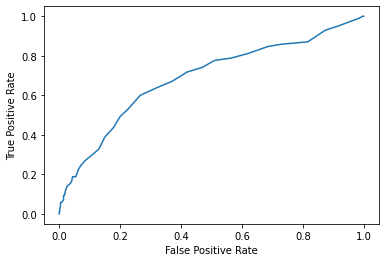

In [9]:

#Gets the true-positive-rate and false-positive rates at a certian threshold
def getROC(y_pred, y_real, thres):

  #format the arrays into numpy
  y_pred = np.array(y_pred)
  y_real = np.array(y_real)

  #get positive and negative counts
  positives = np.count_nonzero(y_real == 1)
  negatives = len(y_real) - positives

  #get the predicted positive and negative values based on the threshold
  pred_pos = np.count_nonzero(y_pred > thres)
  pred_neg = len(y_pred) - pred_pos

  #checks if the class is positive or negative
  def posClass(val):
    return val > thres

  #checks if a value is tp, fp, fn, or tn
  def getConfusion(pred, real):
    if posClass(pred) and real==1:
      return "tp"
    elif posClass(pred) and not real==1:
      return "fp"
    elif not posClass(pred) and real==1:
      return "fn"
    else:
      return "tn"

  #counts the number of true-positives, and false-positives
  tps, fps = 0,0
  for i in range(len(y_real)):

    value = getConfusion(y_pred[i], y_real[i])

    if value == "tp":
      tps +=1
    elif value == "fp":
      fps += 1
  
  #returns the rates
  tpr = tps/positives
  fpr = fps/negatives
  return fpr,tpr



#gets the prediction probabilities
y_pred_proba_val = model.predict_proba(x_val)[:,1] #[:,1] ->only get the second col of the array

#gets the fpr and tpr for a range of values between 0-1
fpr_list, tpr_list = [],[]
for thres in range(100):
  fpr, tpr = getROC(y_pred_proba_val, y_val, thres/100)
  fpr_list.append(fpr)
  tpr_list.append(tpr)
  
#plots the plot
plt.plot(fpr_list, tpr_list)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()



#CHECKING
# #define metrics
# y_pred_proba = model.predict_proba(x_val)[::,1]
# fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_proba)

# # create ROC curve
# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

### d) Interpreting the ROC Curve (4 points)

Using the plot generated in Part (c), what is the False Positive Rate associated with correctly identifying 80% of patients at risk for death in the ICU? Why might a high false positive rate be appropriate in this setting? You can read the answer off the ROC curve plot.


\#ANSWER

When the true positive rate is 0.8, the false positive rate is around 0.5.

A high false positive rate could be appropiate in this setting because it is worse to not treat a patient in need than to spend extra rescources for a patient who doesn't need help.


### e) Modelling Doctors' Decision-Making (6 points)

For this part, produce a short report that answers all the questions below. Include code that produces the numbers that you need.

At the beginning of their shift, a doctor reviews their patients' charts, and decides what intervention is needed for each patient. In the following parts, we will be trying to improve this process. We will consider a simplified version of what is going on. Suppose that if the doctor intervenes correctly, the patient will not die; suppose that the doctor has 60 minutes to look through 25 patient charts; and suppose that the probability of missing the correct treatment if the doctor spends $t$ minutes on reviewing a file is

$$P(\textrm{fail}) = \exp(-t^2/100).$$


1. If the doctor reviews all the files, spends an equal amount of time on each chart, and there are 10 patients who will die without the correct intervention, how many patients are expected to die, if the doctor intervenes when they see that that's needed? What is the percentage of patients who are expected to die, out of 25?

2. Suppose now that the doctor is looking through all the patient charts in the validation set. They would have proportionately more time: $(N/25)\times 60$ minutes in total (where $N$ is the total number of patients in the set). How many patients would be expected to die, if the doctor intervenes correctly when they know they should do that?

3. Now, suppose that the doctor only reviews the files of patients for whom the model outputs a probability of greater than $20\%$. This would give the doctor more time to look through each file, but the doctor would never be able to intervene in the cases of patients form whom the output is $20\%$ or smaller. How many patients would be expected to die?



In [10]:
#get positives and negatives in the validation set
positives_val = np.count_nonzero(y_val == 1)
negatives_val = len(y_val) - positives_val

print("positives =",positives_val, "negatives =",negatives_val)
print(len(y_val))

#get false negatives #anything below threshold is considered negative
def getFalseNegatives(y_pred, y_real, thres):

  #format the arrays into numpy
  y_pred = np.array(y_pred)
  y_real = np.array(y_real)

  #checks if the class is positive or negative
  def posClass(val):
    return val > thres

  #checks if value is a false-negative
  def getConfusion(pred, real):
    if not posClass(pred) and real==1:
      return "fn"
    else:
      return ""

  #counts number of false-negatives
  fns = 0
  for i in range(len(y_real)):
    val = getConfusion(y_pred[i], y_real[i])
    if val == "fn":
      fns += 1

  return fns

#gets the number of predicted positives
def getPredictedPositives(y_pred, thres):
  y_pred = np.array(y_pred)

  #checks if the class is positive or negative
  def posClass(val):
    return val > thres

  #counts number of predicted-positives
  predPos = 0
  for i in range(len(y_pred)):
    if posClass(y_pred[i]):
      predPos += 1

  return predPos

#gets the number of true positives
def getTruePositives(y_pred, y_real, thres):
  y_pred = np.array(y_pred)

  #checks if the class is positive or negative
  def posClass(val):
    return val > thres

  #counts number of predicted-positives
  tps = 0
  for i in range(len(y_pred)):
    if posClass(y_pred[i]) and y_real[i]==1:
      tps += 1

  return tps

def getDeaths(y_pred, y_real, thres):
  deathsFromFalseNegative = getFalseNegatives(y_pred, y_real, thres)
  # print("deathsFromFalseNegative = ",deathsFromFalseNegative)
  predPos = getPredictedPositives(y_pred, thres)
  # print("predPos = ",predPos)
  timeInTotal = (len(y_real)/25)*60
  
  deathsFromNotEnoughTime = 0
  if predPos:
    timePerPatient = timeInTotal / predPos
    # print("timePerPatient",timePerPatient)
    chanceOfDeathForPositivePatient = math.exp(-math.pow(timePerPatient,2)/100)
    # print("chanceOfDeathForPositivePatient",chanceOfDeathForPositivePatient)
    tps = getTruePositives(y_pred, y_real, thres)#get amount of people that are actually ill in the list of people that we think could be ill
    # print("tps=",tps)
    deathsFromNotEnoughTime = round(tps*chanceOfDeathForPositivePatient)
    # print("deathsFromNotEnoughTime=",deathsFromNotEnoughTime)
  return deathsFromNotEnoughTime + deathsFromFalseNegative

# print("fns = ",getFalseNegatives(y_pred_proba_val, y_val, .2))
# print("predPos = ",getPredictedPositives(y_pred_proba_val,.2))
print("Death val",getDeaths(y_pred_proba_val, y_val, .2))
print(len(y_val))

positives = 85 negatives = 643
728
Death val 58
728


\#ANSWER


---


1)

time for each patient = 60/25 = 2.4


chance of death = exp(-2.4^2/100) = 0.944 (94% chance of death)
dead patients= (chance of death)*(positive patients) = .94 * 10 = 9 dead patients

9 out of 10 positive patients will most likley die

2)

728 patients in validation set (after cleaning) <br>
time = (728/25)*60 = 1747.2 minutes<br>
time per patient = (1747.2)/728 = 2.4 minutes<br>
exp(-2.4^2/100) = 0.944 (94% chance of death)<br>

dead patients= (chance of death)*(positive patients) = .94 * 85 = 80 dead patients

80 out of 85 positive patients will most likley die

3)

The number of patients that will die because we are ignoring them is equal to the number of false negatives = 48 dead patients  <br>

The number of patients that will die because we didn't have time for them:  <br>
patients to look at:
predicted positive = 151  <br>
time in total = (728/25)*60  = 1747.2 minutes  <br>
time for each patient = (time in total)/(patients to look at) = 1747.2 / 151 = 11.57 minutes  <br>
chance of death = exp(-11.57^2/100) = 0.262 (26.2% chance of death)  <br>
dealths by not enough time = chance of death * positive patients that we are looking at = 0.262 * 37 = 10  <br>

so in total, 48 patients will die because we misclassified them and about 10 patients will dies because we didn't have enough time for them so about 58 patients will die overall


---



### f) Modelling Doctors' Decision-Making - Revisited (7 points)


In this Part, you will explore the policy implications of using our model in an understaffed hospital. 

Suppose that we are considering a policy of only reviewing the files of patients whose probability of death is above a threshold `thr`. Each chart would be given an equal amount of time, and the total amount of time will be $(N/25)\times 60$.

Using the model from previous part, plot the total number of expected deaths under the policy vs. the threshold. Using the plot, what is the best threshold to use that would minimize the number of deaths?

You should compute the expected number of deaths for the thresholds `np.arange(0, 1, 0.01)`.

Use the validation set.




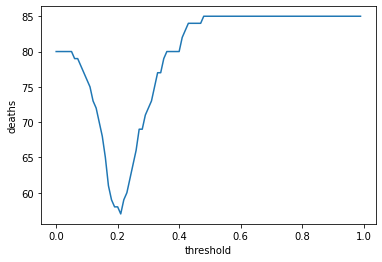

In [11]:

thresholds = np.arange(0, 1, 0.01)

deaths_list = []
fnegs_list = []
for thres in thresholds:
  deaths_list.append(getDeaths(y_pred_proba_val, y_val, thres))

#plots the plot
plt.plot(thresholds, deaths_list)
plt.xlabel('threshold')
plt.ylabel('deaths')
plt.show()


In [12]:
print(min(deaths_list))
print(getDeaths(y_pred_proba_val, y_val, .21))

57
57


\#ANSWER

min amount of deaths is 57 at threshold .21

### g) Modelling Doctors' Decision-Making - Testing (7 points)

On the test set, compare the total number of expected deaths under the best policy that was selected in Part (f) to reviewing each patient's file. In relative terms (i.e., as a percentage), how many lives would be saved, if the assumptions underlying our simulation are accurate?

In [13]:
def getDeathsWithoutClassifier(y_real):
  timeInTotal = (len(y_real)/25)*60
  timePerPatient = timeInTotal / len(y_real)
  chanceOfDeathForPositivePatient = math.exp(-math.pow(timePerPatient,2)/100)
  positives = np.count_nonzero(y_real == 1)
  deathsFromNotEnoughTime = round(positives*chanceOfDeathForPositivePatient)
  return deathsFromNotEnoughTime

y_pred_proba_test = model.predict_proba(x_test)[:,1]



deaths_withProgram = getDeaths(y_pred_proba_test, y_test, .21)
deaths_withoutProgram = getDeathsWithoutClassifier(y_test)
# print("deaths before classifier ",deaths_withoutProgram,"\tdeaths after classifier:",deaths_withProgram)
savedLives = deaths_withoutProgram-deaths_withProgram
print((len(y_test)-deaths_withProgram)/len(y_test)*100, "% people will be alive after all treatment is done" )


89.02606310013718 % people will be alive after all treatment is done


## Question 2 - Neural Networks
---

We will train a fully connected neural networks to recognize face images of cats and dogs. 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [15]:
#my libs
from copy import copy, deepcopy

In [16]:
data_dir = 'pets'
image_width = 32
image_height = 32
batch_size = 10

### a) Load the Pets Dataset (2 points)
There are 110 images of size $32\times32$. Run the following code block to import the data. Keep in mind that they will be downloaded from the internet, so it may take a while.

In [17]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [18]:
#library config
np.set_printoptions(threshold=10)

In [19]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [20]:
# Download the data
downloaded = drive.CreateFile({'id':"1NXiYkupBcolg90e6wE_Nm_F9VTFoXIja"})
downloaded.GetContentFile('pets.npy')  
data = np.load("pets.npy",allow_pickle=True)

In [21]:
# Create X and y
X, y = (data[()]['X'], data[()]['y'])

In [22]:
# Get class names and create ID
class_names = ['cat', 'dog']
class_dict = {i:class_name for i,class_name in enumerate(class_names)}

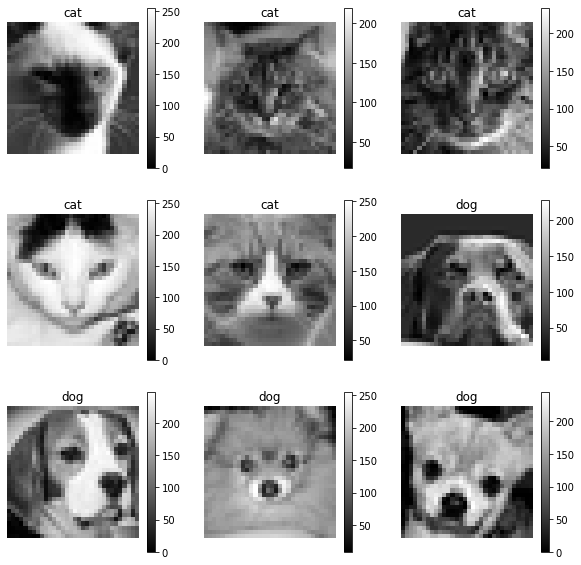

In [23]:
# Plot some images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(X[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

In [24]:
print(class_dict)

print(len(X[0]))

print("yes",X[0][0][0])

print(y)

print(X.shape,y.shape)

{0: 'cat', 1: 'dog'}
32
yes 45
[0 0 0 ... 1 1 1]
(110, 32, 32) (110,)


Answer the following questions:



---


1.) What are the data types for X and y? <br>
\#ANSWER 

Each datapt of X is a 2D array representing a set of pixels of a 32x32 greyscale image where each value in the array is an int of range [0,255] representing the lightness of the pixel where 255 is pure white and 0 is pure black.

Each datapt of y represents a binary classification of its corresponding X-datapt where 0 is 'cat' and 1 is 'dog'



---


2.) What are the shapes of X and y? <br>
\#ANSWER 

X is a 3D array
Y is a 1D array

X shape, y shape = (110, 32, 32), (110, 1)

---


3.) What is the minimum and maximum value of X? <br>
\#ANSWER

range: [0,255]


### b) Data Preprocessing (3 points)
As you can see above, the pixel values are in the [0,255]. This is the normal range for images. Recall from the previous lectures and excercises that we need to normalize our data.

In order to normalize our data to [0,1] we use the equation:

$$x_{norm}=\frac{x-x_{min}}{x_{max}-x_{min}}$$

In our case we can assume that $x_{min}=0$ and $x_{max}=255$, this is a safe assumption since we are working with image data.

This means that for image data, if we want to normlize to [0,1] the equation simplifies to:

$$img_{norm}=\frac{img}{255}$$

Anytime you work with image data in any kind of model you will be normalizing with this equation. Unless the range you want to normalize is different. Sometimes you want to normalize between [-1,1], for that you would use a slightly different equation.


Normalize the X data using the above equation and save as train_images.

In [25]:
def norm_light(val):
  # print(val,'/255 = ',val/255)
  return val/255


train_images = X.astype(float)
for image in train_images:
  for row in image:
    for c in range(len(row)):
      row[c] = norm_light(row[c])
      

# print(train_images)

If we show the image agian, you will see the values are all scaled correctly.

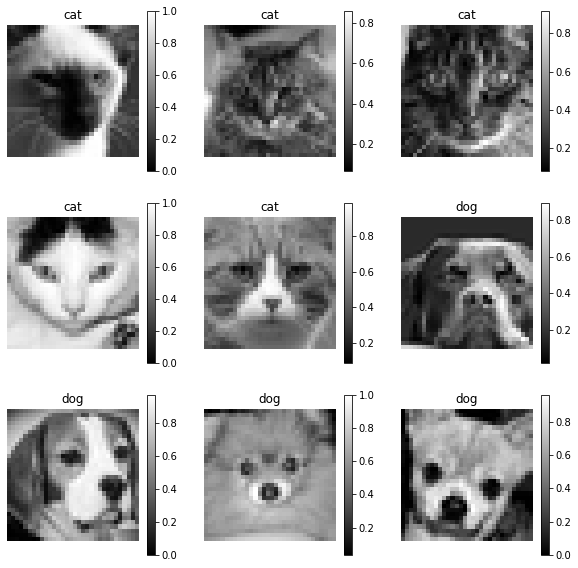

In [26]:
# Plot images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(train_images[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

What is the new minimum and maximum value of X?



---


\#ANSWER

min is 0 = pure black and max is 1 = pure white


---



### c) Reshaping the Data (5 points)

Please reshpe training images to be 1024-dim (from $32 \times 32$). 

Hint: look into numpy.reshape().


In [27]:
print(f'Before reshape, train_images shape: {train_images.shape}')
#HELP
# test = [1,2,3,4]
# test = np.reshape(test,(-1,1024,1024), order='A')

# train_images =

# for image in range(len(train_images)):
#   image = image.resize(row[c], np.zeros(1024-32 + 1024))

train_images = np.reshape(train_images,(-1,1024), order='A')


print(f'Before reshape, train_images shape: {train_images.shape}')


Before reshape, train_images shape: (110, 32, 32)
Before reshape, train_images shape: (110, 1024)


### d) Building a Simple Neural Network (15 points)
In the cell below, build a fully-connected feed-forward neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [28]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

In [29]:
# Build neural network
model = Sequential() 
model.add(Dense(units=25, input_dim=1024,activation='relu')) 
model.add(Dense(units = 1, activation='sigmoid')) 

In [30]:
# Show a summary of your model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                25625     
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 25,651
Trainable params: 25,651
Non-trainable params: 0
_________________________________________________________________


Declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using the 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [31]:
# Declare optimizer
my_optimizer =  SGD(lr=0.001 ,momentum=0.009, decay = 1e-6)

# Compile model
# YOUR CODE HERE
model.compile(loss='binary_crossentropy', 
                           optimizer = my_optimizer, #weight_decay was missing from: https://keras.io/api/optimizers/sgd/ #HELP
                           metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Now we will train our model to learn pet faces using train_images and the 'y' labels. Our dataset is small so we will use 10% of the data as test set data. Train your model using the following parameters:

Fit your model using the train_images, 'y' labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

.fit documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [32]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist =  model.fit(train_images, y, epochs = 500, batch_size=10, validation_split = 0.1)

Epoch 1/500
10/10 [==============================] - 2s 73ms/step - loss: 0.7209 - accuracy: 0.4949 - val_loss: 0.6557 - val_accuracy: 0.7273
Epoch 2/500
10/10 [==============================] - 0s 19ms/step - loss: 0.7102 - accuracy: 0.5152 - val_loss: 0.6889 - val_accuracy: 0.6364
Epoch 3/500
10/10 [==============================] - 0s 18ms/step - loss: 0.7022 - accuracy: 0.5152 - val_loss: 0.7132 - val_accuracy: 0.4545
Epoch 4/500
10/10 [==============================] - 0s 11ms/step - loss: 0.6966 - accuracy: 0.5556 - val_loss: 0.7305 - val_accuracy: 0.4545
Epoch 5/500
10/10 [==============================] - 0s 13ms/step - loss: 0.6925 - accuracy: 0.5758 - val_loss: 0.7431 - val_accuracy: 0.3636
Epoch 6/500
10/10 [==============================] - 0s 11ms/step - loss: 0.6868 - accuracy: 0.5960 - val_loss: 0.7532 - val_accuracy: 0.3636
Epoch 7/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6830 - accuracy: 0.6061 - val_loss: 0.7609 - val_accuracy: 0.2727
Epoch 8

In [33]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

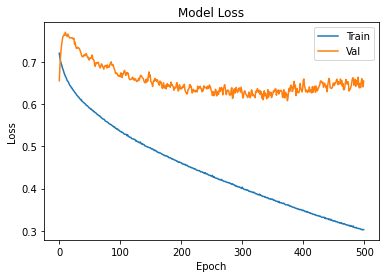

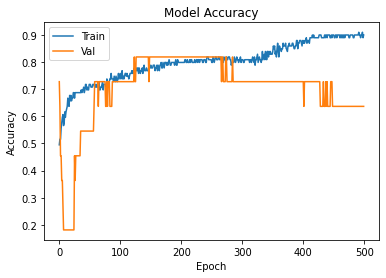

In [34]:
# plot your losses and accuracies
plot_losses(hist) #HELP
plot_accuracies(hist)

In [35]:
print("min loss:",min(hist.history['val_loss']))
print("end loss:",hist.history['val_loss'][499])
print("end accuracy:",hist.history['val_accuracy'][499])

min loss: 0.6082853674888611
end loss: 0.6551231741905212
end accuracy: 0.6363636255264282


For the input size, this one hidden layer neural network is probably too small. However, we can see that the model attempts to minimize the overall loss. Summarize your observations on the model's learning curves, model's overall classification accuracy on the validation set, and the least amount of loss on validation set?

\#ANSWER


---


The model's loss grows for the validation set the more we train which mean that the model is not generalized and is overfitting to the training set. We can see this in the accuracy as well since the model becomes less accurate on the validation set as we train it more.


---



### e) Building a Second Neural Network (15 points)
Next, you will build a neural network with one hidden layer that is wider than the previous model's hidden layer. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [36]:
# Build Neural network
model = Sequential() 
model.add(Dense(units=100, input_dim=1024,activation='relu')) 
model.add(Dense(units = 1, activation='sigmoid')) 

In [37]:
# Show a summary of your model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               102500    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


Again, declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [38]:
# Declare optimizer
my_optimizer =  SGD(lr=0.001 ,momentum=0.009, decay = 1e-6)

# Compile model
# YOUR CODE HERE
model.compile(loss='binary_crossentropy', 
                           optimizer = my_optimizer, #weight_decay was missing from: https://keras.io/api/optimizers/sgd/ 
                           metrics = ['accuracy'])

In this sell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [39]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist =  model.fit(train_images, y, epochs = 500, batch_size=10, validation_split = 0.1)

Epoch 1/500
10/10 [==============================] - 1s 23ms/step - loss: 0.7579 - accuracy: 0.5657 - val_loss: 1.1465 - val_accuracy: 0.0000e+00
Epoch 2/500
10/10 [==============================] - 0s 5ms/step - loss: 0.7299 - accuracy: 0.5657 - val_loss: 1.0498 - val_accuracy: 0.0000e+00
Epoch 3/500
10/10 [==============================] - 0s 6ms/step - loss: 0.7107 - accuracy: 0.5657 - val_loss: 0.9717 - val_accuracy: 0.0000e+00
Epoch 4/500
10/10 [==============================] - 0s 6ms/step - loss: 0.6998 - accuracy: 0.5455 - val_loss: 0.9300 - val_accuracy: 0.0000e+00
Epoch 5/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5758 - val_loss: 0.9060 - val_accuracy: 0.0000e+00
Epoch 6/500
10/10 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5859 - val_loss: 0.8851 - val_accuracy: 0.0000e+00
Epoch 7/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6806 - accuracy: 0.5859 - val_loss: 0.8705 - val_accur

In [40]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

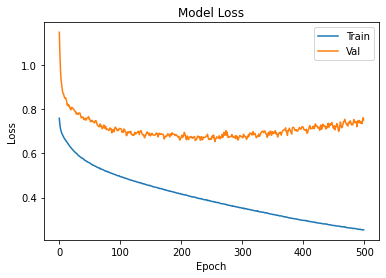

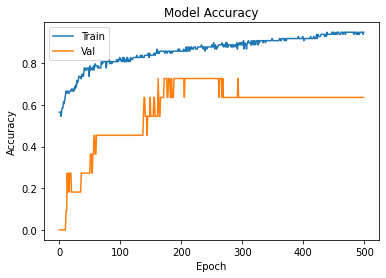

In [41]:
# Plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

In [42]:
print("min loss:",min(hist.history['val_loss']))
print("end loss:",hist.history['val_loss'][499])
print("end accuracy:",hist.history['val_accuracy'][499])

min loss: 0.6526621580123901
end loss: 0.7511394023895264
end accuracy: 0.6363636255264282


Next, summarize this models results. Consider the following questions when answering. Remember that this model has a higher learning capacity than the previous model. 

1) How did this model compare to previous model? 

Even though this model has a higher learning capacity than the previous model, it performed about the same with 72% accuracy.

2) Did it outperform the previous models? 

No

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

val_accuracy: 0.7273 <br>
least loss: .27

### f) Building a Third Neural Network (15 points)
Lastly, you will build a fully-connected neural network with two hidden layers. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [43]:
from tensorflow.keras.layers import Input, Dense # only use these layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import * # you can use any optimizer

# Build Neural network
model = Sequential() 
model.add(Dense(units=100, input_dim=1024, activation='relu')) 
model.add(Dense(units = 25, activation='relu')) 
model.add(Dense(units = 1, activation='sigmoid')) 

In [44]:
# Show a summary of your model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               102500    
                                                                 
 dense_5 (Dense)             (None, 25)                2525      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 105,051
Trainable params: 105,051
Non-trainable params: 0
_________________________________________________________________


Since this model is bigger than the previous models, we will use a more powerful optimizer. Declare the optimizer as Adam with learning rate of 0.001. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [45]:
# Declare optimizer
my_optimizer =  Adam(lr=0.001)

# Compile model
model.compile(loss='binary_crossentropy', 
                           optimizer = my_optimizer,
                           metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In this sell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [46]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y. 
# Train for 500 epochs with a batch size of 10 and validation split of 0.1
hist =  model.fit(train_images, y, batch_size = 10, epochs = 500, validation_split = 0.1)

Epoch 1/500
10/10 [==============================] - 1s 23ms/step - loss: 0.6382 - accuracy: 0.6667 - val_loss: 0.6626 - val_accuracy: 0.7273
Epoch 2/500
10/10 [==============================] - 0s 7ms/step - loss: 0.5397 - accuracy: 0.7273 - val_loss: 0.9147 - val_accuracy: 0.1818
Epoch 3/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4851 - accuracy: 0.7374 - val_loss: 1.0162 - val_accuracy: 0.1818
Epoch 4/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4597 - accuracy: 0.7879 - val_loss: 1.1241 - val_accuracy: 0.0000e+00
Epoch 5/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4243 - accuracy: 0.8182 - val_loss: 0.7948 - val_accuracy: 0.4545
Epoch 6/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4475 - accuracy: 0.7475 - val_loss: 1.1808 - val_accuracy: 0.1818
Epoch 7/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4111 - accuracy: 0.8485 - val_loss: 1.0651 - val_accuracy: 0.2727
Epoch 8/

In [47]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

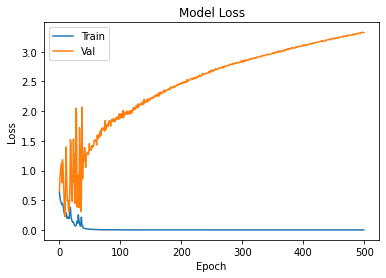

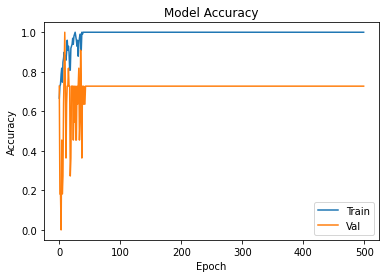

In [48]:
# plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

In [49]:
print("min loss:",min(hist.history['val_loss']))
print("end loss:",hist.history['val_loss'][499])
print("end accuracy:",hist.history['val_accuracy'][499])

min loss: 0.22335267066955566
end loss: 3.3209617137908936
end accuracy: 0.7272727489471436


Summarize this model's results. Consider the following when answering:

1) How did this model compare to previous models? 

This model did much better because it had about 10% more accuracy than the previous models by the end. The loss however was greater which meant that errors were much greater when they were present.

2) Did it outperform the previous models? 

Yes, 10% more accuracy.

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

min loss: 0.2712278962135315
end accuracy: 0.7272727489471436

4) Adam is a powerful optimizer, and may quickly converge to an a minima. Did this happen with this model?

Yes, the model converged at around 30 epochs.